> **original paper:** https://arxiv.org/abs/1505.04597

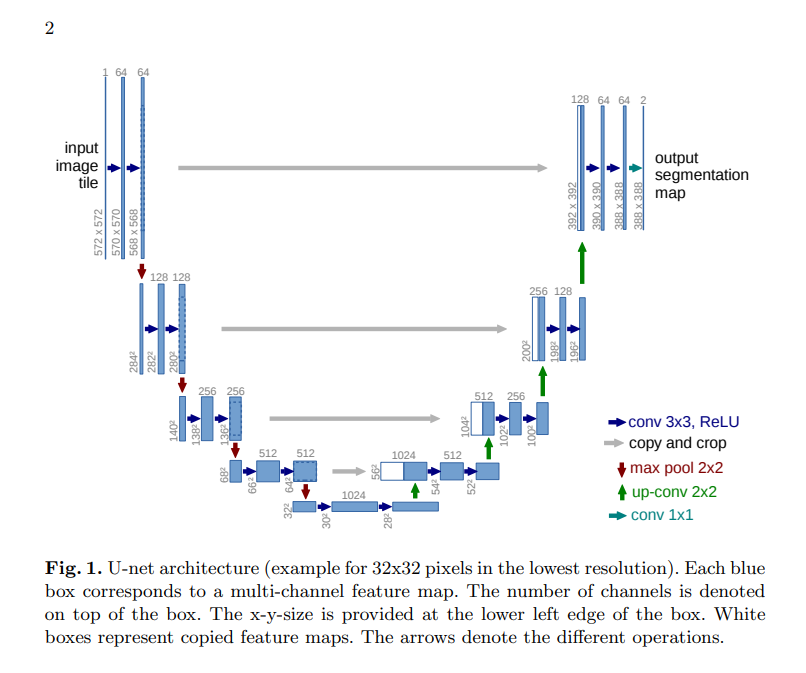


In [1]:
import tensorflow as tf

print(tf.__version__)

2.8.2


In [2]:
# generate convolution block
def conv2d_block(tensor, n_filters, kernel_size=3):

    x = tensor
    x = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal',
                               strides=(1, 1), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal',
                               strides=(1, 1), padding='same', activation='relu')(x)                           

    return x

In [3]:
# encoder
def encoder_block(inputs, n_filters=64, pool_size=(2,2), drop=0.2):
 
    conved = conv2d_block(inputs, n_filters)
    pooled = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(conved)
    dropped = tf.keras.layers.Dropout(drop)(pooled)
 
    return conved, dropped

def encoder(inputs):
    
    s1, b1 = encoder_block(inputs, n_filters=64)
    s2, b2 = encoder_block(b1, n_filters=128)
    s3, b3 = encoder_block(b2, n_filters=256)
    s4, b4 = encoder_block(b3, n_filters=512)
 
    return b4, (s1, s2, s3, s4)

In [4]:
# bottleneck
def bottleneck(tensor, n_filters=1024):

    x = conv2d_block(tensor, 1024)

    return x

In [5]:
# decoder
def decoder_block(tensor, conv_output, n_filters=64, kernel_size=3, strides=2, drop=0.2):
 
    upsampled = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides, padding='same')(tensor)
    concated = tf.keras.layers.concatenate([upsampled, conv_output])
    dropped = tf.keras.layers.Dropout(drop)(concated)
    c = conv2d_block(dropped, n_filters)
 
    return c
 
def decoder(inputs, convs, output_channels):

    s1, s2, s3, s4 = convs
    print(s1.shape)
    print(s2.shape)
    print(s3.shape)
    print(s4.shape)
 
    d1 = decoder_block(inputs, s4, n_filters=512, kernel_size=3, strides=2)
    d2 = decoder_block(d1, s3, n_filters=256, kernel_size=3, strides=2)
    d3 = decoder_block(d2, s2, n_filters=128, kernel_size=3, strides=2)
    d4 = decoder_block(d3, s1, n_filters=64, kernel_size=3, strides=2)

    # output_channels = len(categories_to_be_classified)
    outputs = tf.keras.layers.Conv2D(output_channels, kernel_size=1, activation='softmax')(d4)
 
    return outputs

In [6]:
# model architecture
def Unet(shape):
    
    output_channels = 2 # binary

    # put input data shape
    input = tf.keras.layers.Input(shape=shape)

    v1, skip_conv_list = encoder(input)
    b = bottleneck(v1, n_filters=1024)
    output = decoder(b, skip_conv_list, output_channels)

    model = tf.keras.Model(input, output)

    return model

In [7]:
# build model
def build_model(shape):

    model = Unet(shape)
    model.summary()
    model.compile(optimizer='adam', loss='BinaryCrossEntrophy', metrics='acc')

    return model

In [ ]:
shape = (48, 768, 1)
model = build_model(shape)

(None, 48, 768, 64)
(None, 24, 384, 128)
(None, 12, 192, 256)
(None, 6, 96, 512)
